<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/dECM5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import re
import numpy as np
import pandas as pd

def load_bmg_kinetic_clean(filepath, sheet_name=0):
    """
    Lee un Excel BMG con:
      - sección 'Layout' donde se asigna SPL a cada pocillo (A–H x columnas)
      - varios bloques "350 - Time [hh:mm:ss]" con lecturas OD

    Devuelve un DataFrame largo con:
      time_min, row, col, sample_id, od
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)

    # ---------- 1) Leer LAYOUT: (row_letter, col_num) -> sample_id ----------
    # Buscar la fila donde la primera celda es "Layout"
    layout_idx_list = df.index[df.iloc[:, 0] == 'Layout'].tolist()
    if not layout_idx_list:
        raise ValueError("No se ha encontrado la fila 'Layout' en el Excel.")
    layout_idx = layout_idx_list[0]

    # Fila con números de columna (normalmente layout_idx+2)
    colnums_row = df.iloc[layout_idx + 2, :]
    well_cols_pos = [
        pos for pos, val in enumerate(colnums_row)
        if isinstance(val, (int, float)) and not pd.isna(val)
    ]

    # Filas con A–H debajo del layout
    layout_rows_idx = range(layout_idx + 3, layout_idx + 11)  # 8 filas
    well_to_sample = {}

    for i in layout_rows_idx:
        row_letter = df.iloc[i, 1]
        if not isinstance(row_letter, str):
            continue
        for pos in well_cols_pos:
            col_num = int(colnums_row.iloc[pos])
            sample_id = df.iloc[i, pos]
            if isinstance(sample_id, str) and sample_id.strip() != "":
                well_to_sample[(row_letter, col_num)] = sample_id.strip()

    # ---------- 2) Leer bloques de tiempo 350 nm ----------
    records = []
    nrows = df.shape[0]

    # filas donde aparece "350 - Time"
    time_rows = df.index[
        df.iloc[:, 0].astype(str).str.contains('350 - Time', na=False)
    ].tolist()

    for t_idx in time_rows:
        # 2.1. sacar tiempo (en minutos) de la cadena
        time_str = str(df.iloc[t_idx, 0])
        m = re.search(r'\((\d+):(\d+):(\d+)\)', time_str)
        if m:
            h, mn, s = map(int, m.groups())
            time_min = (h * 3600 + mn * 60 + s) / 60.0
        else:
            # si no hay formato hh:mm:ss, intentamos convertir directamente
            try:
                time_min = float(df.iloc[t_idx, 1])
            except Exception:
                time_min = np.nan

        # 2.2. buscar la fila de cabecera de columnas (números)
        header_idx = None
        header_numeric_pos = None
        for cand in range(t_idx + 1, min(t_idx + 20, nrows)):
            row = df.iloc[cand, :]
            numeric_pos = [
                pos for pos, val in enumerate(row)
                if isinstance(val, (int, float)) and not pd.isna(val)
            ]
            if len(numeric_pos) >= 3:
                header_idx = cand
                header_numeric_pos = numeric_pos
                break

        if header_idx is None:
            continue

        # 2.3. las 8 filas siguientes son A–H con los valores OD
        data = df.iloc[header_idx + 1:header_idx + 1 + 8, :]

        for i in range(data.shape[0]):
            row_letter = data.iloc[i, 1]
            if not isinstance(row_letter, str):
                continue
            for pos in header_numeric_pos:
                val_header = df.iloc[header_idx, pos]
                if pd.isna(val_header):
                    continue
                col_num = int(val_header)

                val_od = data.iloc[i, pos]
                if pd.isna(val_od):
                    continue

                sample_id = well_to_sample.get((row_letter, col_num))
                if sample_id is None:
                    # pocillo sin asignar en el layout → lo ignoramos
                    continue

                records.append({
                    'time_min': float(time_min),
                    'row': row_letter,
                    'col': col_num,
                    'sample_id': sample_id,
                    'od': float(val_od),
                })

    long_df = pd.DataFrame.from_records(records)
    return long_df


In [17]:
# 1) Crear long_df leyendo el Excel
long_df = load_bmg_kinetic_clean("dECM5PEP_NOPEP.xlsx")

print(long_df.head())
print(long_df.shape)

# 2) Crear meta_df con tu mapping A–G (la función que ya tienes)
meta_df = build_meta_from_rowcol(long_df)

# 3) Unir metadatos
long_meta = long_df.merge(meta_df, on=['row', 'col', 'sample_id'], how='left')

print(long_meta.head())


   time_min row  col sample_id     od
0       0.2   A    1      SPL1  0.189
1       0.2   A    2      SPL5  0.174
2       0.2   A    3      SPL9  0.151
3       0.2   A    4     SPL13  1.318
4       0.2   A    5     SPL17  0.510
(4719, 5)
   time_min row  col sample_id     od group  type  paa  hours pepsin
0       0.2   A    1      SPL1  0.189     A  dECM  PAA   24.0   True
1       0.2   A    2      SPL5  0.174     A  dECM  PAA   24.0   True
2       0.2   A    3      SPL9  0.151     A  dECM  PAA   24.0   True
3       0.2   A    4     SPL13  1.318     A  dECM  PAA   24.0  False
4       0.2   A    5     SPL17  0.510     A  dECM  PAA   24.0  False


/tmp/ipython-input-2240836760.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


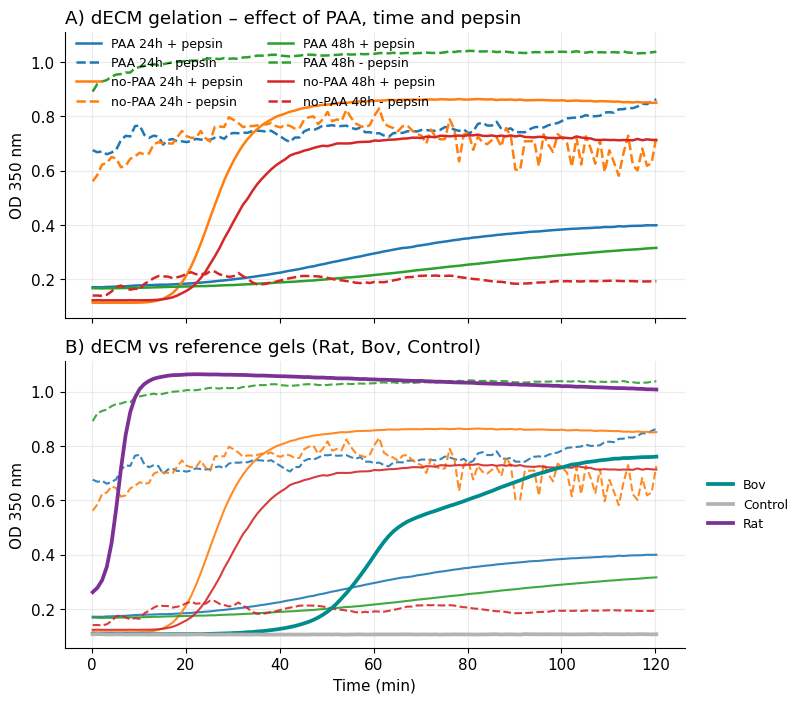

In [18]:
plot_decem_vs_controls_paper(long_meta)


/tmp/ipython-input-2240836760.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


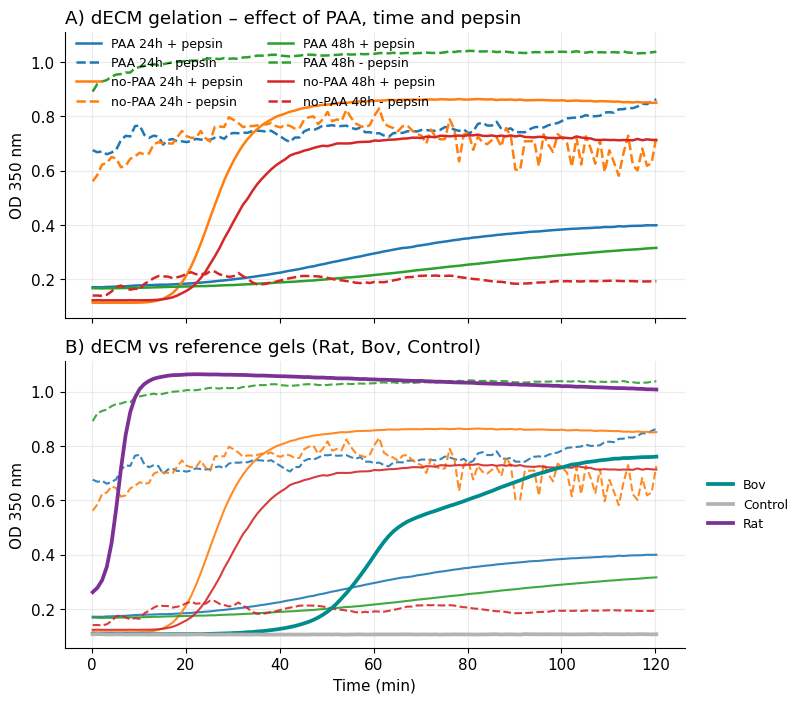

In [19]:
def prepare_decem_summary(long_meta):
    decmdf = long_meta[long_meta['type'] == 'dECM'].copy()
    decmdf['hours'] = decmdf['hours'].astype(int)
    decmdf['cond_core'] = decmdf['paa'] + ' ' + decmdf['hours'].astype(str) + 'h'
    decmdf['pepsin_status'] = decmdf['pepsin'].map({True: '+ pepsin', False: '- pepsin'})
    decmdf['condition_label'] = decmdf['cond_core'] + ' ' + decmdf['pepsin_status']

    summary = (
        decmdf
        .groupby(['time_min', 'cond_core', 'pepsin_status', 'condition_label'])['od']
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    return summary

def prepare_controls_summary(long_meta):
    rbc = long_meta[long_meta['type'].isin(['Rat', 'Bov', 'Control'])].copy()
    rbc['condition_label'] = rbc['type']
    summary = (
        rbc
        .groupby(['time_min', 'condition_label'])['od']
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    return summary

def plot_decem_vs_controls_paper(long_meta):
    summary_dECM = prepare_decem_summary(long_meta)
    summary_rbc = prepare_controls_summary(long_meta)

    # Colores dECM
    color_map_dECM = {
        'PAA 24h':    '#1f77b4',  # azul
        'no-PAA 24h': '#ff7f0e',  # naranja
        'PAA 48h':    '#2ca02c',  # verde
        'no-PAA 48h': '#d62728',  # rojo
    }
    core_order = ['PAA 24h', 'no-PAA 24h', 'PAA 48h', 'no-PAA 48h']
    linestyle_map = {'+ pepsin': '-', '- pepsin': '--'}

    # Colores controles (bien distintivos)
    color_map_ctrl = {
        'Rat':     '#7b3294',   # morado
        'Bov':     '#008c8c',   # verde azulado
        'Control': '#b3b3b3',   # gris
    }

    plt.rcParams.update({
        'font.size': 11,
        'axes.spines.top': False,
        'axes.spines.right': False,
    })

    fig, axes = plt.subplots(
        2, 1,
        figsize=(8, 8),
        sharex=True,
        sharey=True,
        gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.15}
    )
    ax1, ax2 = axes

    # -------- PANEL A: solo dECM --------
    for cond_core in core_order:
        for peps in ['+ pepsin', '- pepsin']:
            mask = (summary_dECM['cond_core'] == cond_core) & \
                   (summary_dECM['pepsin_status'] == peps)
            df_cond = summary_dECM[mask]
            if df_cond.empty:
                continue
            ax1.plot(
                df_cond['time_min'], df_cond['mean'],
                linestyle=linestyle_map[peps],
                color=color_map_dECM[cond_core],
                linewidth=1.8,
                label=f"{cond_core} {peps}"
            )

    ax1.set_ylabel("OD 350 nm")
    ax1.set_title("A) dECM gelation – effect of PAA, time and pepsin", loc='left')
    ax1.grid(True, alpha=0.25)
    ax1.legend(
        fontsize=9, ncol=2, frameon=False,
        loc='upper left', bbox_to_anchor=(0.0, 1.02)
    )

    # -------- PANEL B: dECM + Rat/Bov/Control --------
    # dECM
    for cond_core in core_order:
        for peps in ['+ pepsin', '- pepsin']:
            mask = (summary_dECM['cond_core'] == cond_core) & \
                   (summary_dECM['pepsin_status'] == peps)
            df_cond = summary_dECM[mask]
            if df_cond.empty:
                continue
            ax2.plot(
                df_cond['time_min'], df_cond['mean'],
                linestyle=linestyle_map[peps],
                color=color_map_dECM[cond_core],
                linewidth=1.5,
                alpha=0.9,
            )

    # Controles
    for cond_label, df_ctrl in summary_rbc.groupby('condition_label'):
        ax2.plot(
            df_ctrl['time_min'], df_ctrl['mean'],
            linestyle='-',
            color=color_map_ctrl[cond_label],
            linewidth=2.7,
            label=cond_label
        )

    ax2.set_xlabel("Time (min)")
    ax2.set_ylabel("OD 350 nm")
    ax2.set_title("B) dECM vs reference gels (Rat, Bov, Control)", loc='left')
    ax2.grid(True, alpha=0.25)
    ax2.legend(
        fontsize=9, frameon=False,
        loc='center left', bbox_to_anchor=(1.02, 0.5)
    )

    fig.tight_layout()
    plt.show()

# Llamada final:
plot_decem_vs_controls_paper(long_meta)


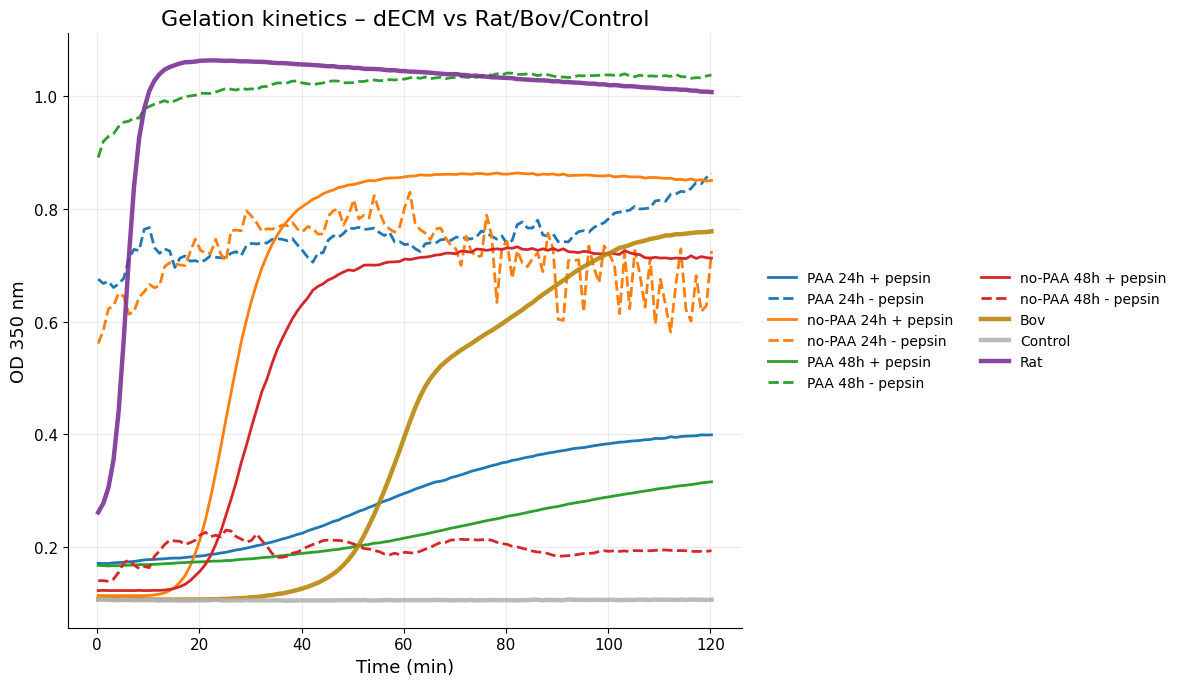

In [20]:
import matplotlib.pyplot as plt

# Resumen dECM
summary_dECM = prepare_decem_summary(long_meta)
# Resumen controles
summary_rbc = prepare_controls_summary(long_meta)

# Colores dECM
color_map_dECM = {
    'PAA 24h':    '#1f77b4',
    'no-PAA 24h': '#ff7f0e',
    'PAA 48h':    '#2ca02c',
    'no-PAA 48h': '#d62728',
}

core_order = ['PAA 24h', 'no-PAA 24h', 'PAA 48h', 'no-PAA 48h']
linestyle_map = {'+ pepsin': '-', '- pepsin': '--'}

# Colores controles (bien diferenciados)
color_map_ctrl = {
    'Rat':     '#7b3294',   # morado
    'Bov': '#b8860b',   # verde azulado
    'Control': '#b3b3b3',   # gris
}

plt.figure(figsize=(12, 7))

# -------------------------
# PLOT dECM
# -------------------------
for cond_core in core_order:
    for peps in ['+ pepsin', '- pepsin']:
        df_cond = summary_dECM[
            (summary_dECM['cond_core'] == cond_core) &
            (summary_dECM['pepsin_status'] == peps)
        ]
        if df_cond.empty:
            continue

        plt.plot(
            df_cond['time_min'],
            df_cond['mean'],
            linestyle=linestyle_map[peps],
            color=color_map_dECM[cond_core],
            linewidth=2,
            label=f"{cond_core} {peps}"
        )

# -------------------------
# PLOT CONTROLES
# -------------------------
for cond_label, df_ctrl in summary_rbc.groupby('condition_label'):
    plt.plot(
        df_ctrl['time_min'],
        df_ctrl['mean'],
        linestyle='-',
        color=color_map_ctrl[cond_label],
        linewidth=3.2,
        alpha=0.9,
        label=cond_label
    )

# -------------------------
# Estética de la figura
# -------------------------
plt.xlabel("Time (min)", fontsize=13)
plt.ylabel("OD 350 nm", fontsize=13)
plt.title("Gelation kinetics – dECM vs Rat/Bov/Control", fontsize=16)

plt.grid(True, alpha=0.25)

# Leyenda grande y clara
plt.legend(
    fontsize=10,
    frameon=False,
    ncol=2,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


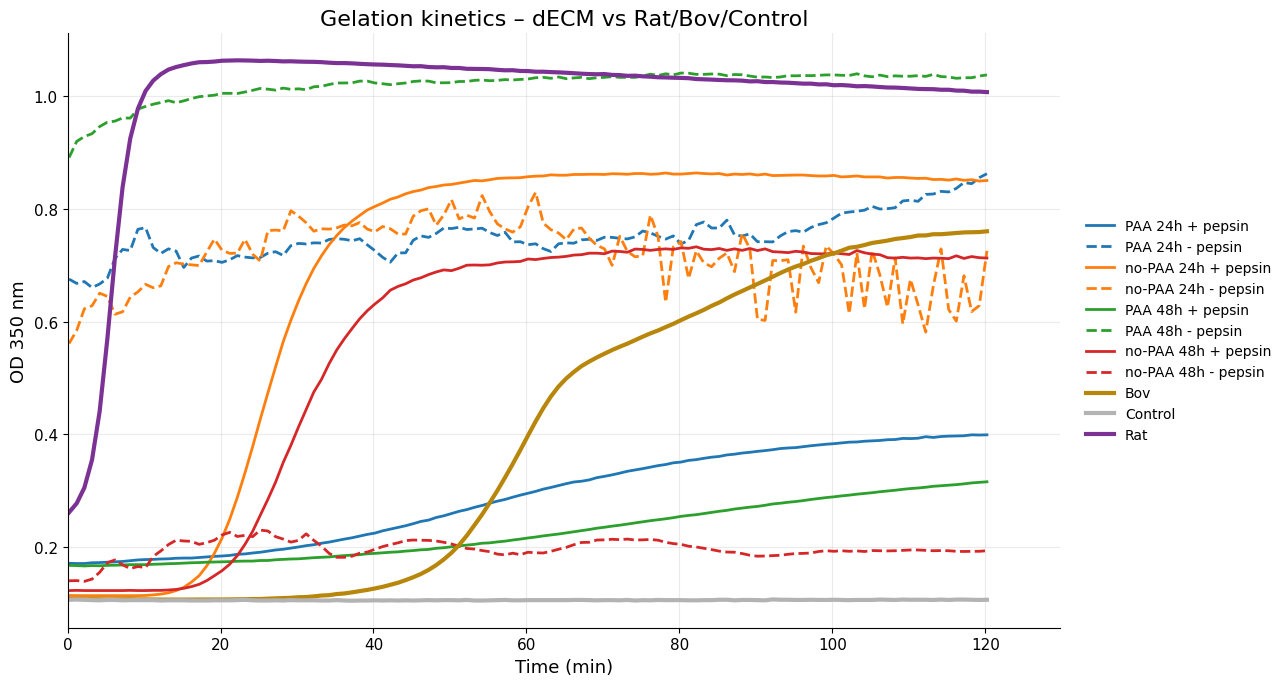

In [21]:
plt.figure(figsize=(13, 7))

# --- dECM ---
for cond_core in core_order:
    for peps in ['+ pepsin', '- pepsin']:
        df_cond = summary_dECM[
            (summary_dECM['cond_core'] == cond_core) &
            (summary_dECM['pepsin_status'] == peps)
        ]
        if df_cond.empty:
            continue

        plt.plot(
            df_cond['time_min'],
            df_cond['mean'],
            linestyle=linestyle_map[peps],
            color=color_map_dECM[cond_core],
            linewidth=2,
            label=f"{cond_core} {peps}"
        )

# --- Controles ---
for cond_label, df_ctrl in summary_rbc.groupby('condition_label'):
    plt.plot(
        df_ctrl['time_min'],
        df_ctrl['mean'],
        linestyle='-',
        color=color_map_ctrl[cond_label],
        linewidth=3,
        label=f"{cond_label}"
    )

# ---- ESTÉTICA ----
plt.xlabel("Time (min)", fontsize=13)
plt.ylabel("OD 350 nm", fontsize=13)
plt.title("Gelation kinetics – dECM vs Rat/Bov/Control", fontsize=16)
plt.grid(True, alpha=0.25)

# 🔥 EJE X EXPANDIDO
plt.xlim(0, summary_dECM['time_min'].max() * 1.08)

# 🔥 LEYENDA GRANDE, UNA POR LÍNEA
plt.legend(
    fontsize=10,
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    borderaxespad=0
)

plt.tight_layout()
plt.show()


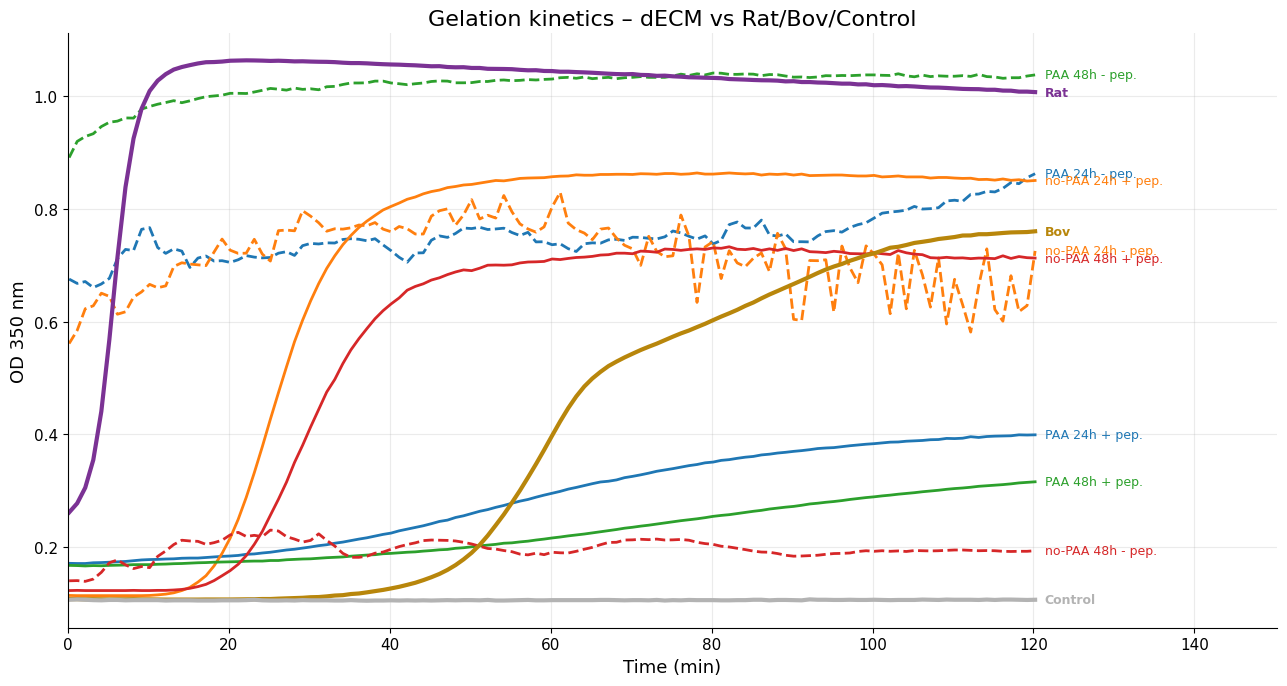

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 7))

# Para calcular luego el xlim
xmax_d = summary_dECM['time_min'].max() if not summary_dECM.empty else 0
xmax_c = summary_rbc['time_min'].max() if not summary_rbc.empty else 0
xmax = max(xmax_d, xmax_c)

# --- dECM ---
for cond_core in core_order:
    for peps in ['+ pepsin', '- pepsin']:
        df_cond = summary_dECM[
            (summary_dECM['cond_core'] == cond_core) &
            (summary_dECM['pepsin_status'] == peps)
        ]
        if df_cond.empty:
            continue

        df_cond = df_cond.sort_values('time_min')

        x = df_cond['time_min'].values
        y = df_cond['mean'].values

        color = color_map_dECM[cond_core]
        ls = linestyle_map[peps]

        plt.plot(x, y, linestyle=ls, color=color, linewidth=2)

        # Etiqueta al final de la curva
        label_text = f"{cond_core} {peps}".replace("pepsin", "pep.")
        plt.text(
            x[-1] * 1.01,    # un pelín a la derecha del último punto
            y[-1],
            label_text,
            color=color,
            fontsize=9,
            va='center'
        )

# --- Controles ---
for cond_label, df_ctrl in summary_rbc.groupby('condition_label'):
    df_ctrl = df_ctrl.sort_values('time_min')

    x = df_ctrl['time_min'].values
    y = df_ctrl['mean'].values

    color = color_map_ctrl[cond_label]

    plt.plot(x, y, linestyle='-', color=color, linewidth=3)

    # Etiqueta al final de cada control
    plt.text(
        x[-1] * 1.01,
        y[-1],
        cond_label,
        color=color,
        fontsize=9,
        va='center',
        fontweight='bold'   # para que controles destaquen un poco
    )

# --- estética general ---
plt.xlabel("Time (min)", fontsize=13)
plt.ylabel("OD 350 nm", fontsize=13)
plt.title("Gelation kinetics – dECM vs Rat/Bov/Control", fontsize=16)
plt.grid(True, alpha=0.25)

# Eje X expandido para que quepan las etiquetas
plt.xlim(0, xmax * 1.25)

# Muy importante: SIN legend()
# plt.legend()  # <- NO lo usamos

plt.tight_layout()
plt.show()


In [23]:
# Colores dECM: (cond_core, pepsin_status)
# cond_core = 'no-PAA 24h', 'PAA 24h', 'no-PAA 48h', 'PAA 48h'
# pepsin_status = '+ pepsin' / '- pepsin'

color_map_dECM = {
    ('no-PAA 24h', '+ pepsin'): '#fdae61',  # naranja
    ('no-PAA 24h', '- pepsin'): '#fee08b',  # naranja claro

    ('PAA 24h',    '+ pepsin'): '#984ea3',  # morado
    ('PAA 24h',    '- pepsin'): '#e6c4f2',  # morado claro

    ('no-PAA 48h', '+ pepsin'): '#00bfc4',  # cian
    ('no-PAA 48h', '- pepsin'): '#b2e2e2',  # cian claro

    ('PAA 48h',    '+ pepsin'): '#d73027',  # rojo
    ('PAA 48h',    '- pepsin'): '#f4a6a6',  # rojo claro
}

# Colores controles (como en la figura de R)
color_map_ctrl = {
    'Rat':     '#4575b4',  # azul
    'Bov':     '#1a9850',  # verde
    'Control': '#000000',  # negro
}

# (si quieres puedes seguir usando linestyle_map para continuo/discontinuo)
linestyle_map = {'+ pepsin': '-', '- pepsin': '--'}

core_order = ['no-PAA 24h', 'PAA 24h', 'no-PAA 48h', 'PAA 48h']


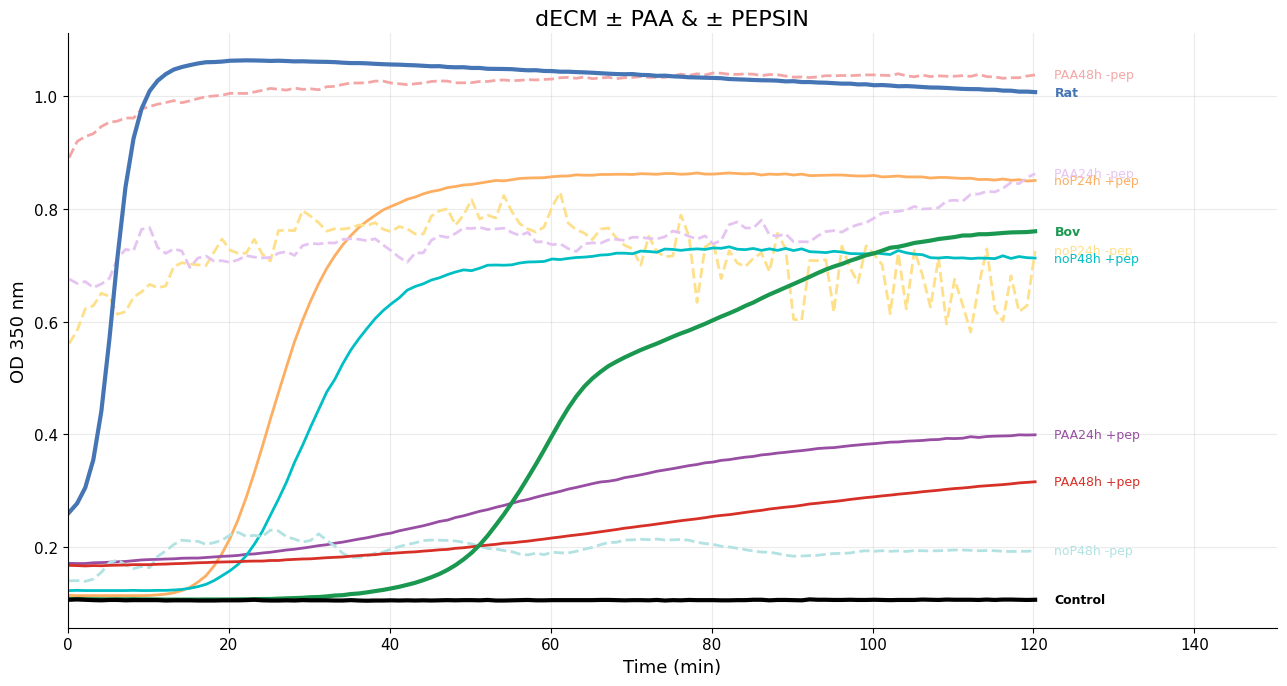

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(13, 7))

xmax_d = summary_dECM['time_min'].max() if not summary_dECM.empty else 0
xmax_c = summary_rbc['time_min'].max() if not summary_rbc.empty else 0
xmax = max(xmax_d, xmax_c)

# ---- dECM ----
for cond_core in core_order:
    for peps in ['+ pepsin', '- pepsin']:
        df_cond = summary_dECM[
            (summary_dECM['cond_core'] == cond_core) &
            (summary_dECM['pepsin_status'] == peps)
        ]
        if df_cond.empty:
            continue

        df_cond = df_cond.sort_values('time_min')
        x = df_cond['time_min'].values
        y = df_cond['mean'].values

        color = color_map_dECM[(cond_core, peps)]
        ls = linestyle_map[peps]

        plt.plot(x, y, linestyle=ls, color=color, linewidth=2)

        # Etiqueta cortita al final de cada curva
        short = cond_core.replace('no-PAA', 'noP').replace(' ', '')  # ej. 'noPAA24h'
        tag = f"{short}{' +pep' if peps=='+ pepsin' else ' -pep'}"
        plt.text(
            x[-1] * 1.02,
            y[-1],
            tag,
            color=color,
            fontsize=9,
            va='center'
        )

# ---- Controles ----
for cond_label, df_ctrl in summary_rbc.groupby('condition_label'):
    df_ctrl = df_ctrl.sort_values('time_min')
    x = df_ctrl['time_min'].values
    y = df_ctrl['mean'].values

    color = color_map_ctrl[cond_label]

    plt.plot(x, y, linestyle='-', color=color, linewidth=3)

    plt.text(
        x[-1] * 1.02,
        y[-1],
        cond_label,
        color=color,
        fontsize=9,
        va='center',
        fontweight='bold'
    )

# ---- estética ----
plt.xlabel("Time (min)", fontsize=13)
plt.ylabel("OD 350 nm", fontsize=13)
plt.title("dECM ± PAA & ± PEPSIN", fontsize=16)
plt.grid(True, alpha=0.25)
plt.xlim(0, xmax * 1.25)  # espacio a la derecha para las etiquetas

# Sin legend(), porque ya etiquetamos cada línea
plt.tight_layout()
plt.show()


In [25]:
import matplotlib.colors as mc
import colorsys

def pastel(color, factor=0.4):
    """
    Devuelve un pastel del mismo color.
    factor pequeño = color más claro
    factor grande = más fuerte
    """
    c = mc.to_rgb(color)
    # Convertimos a HLS para aclarar
    h, l, s = colorsys.rgb_to_hls(*c)
    # subimos la luminosidad ligeramente
    l = min(1, l + factor * (1 - l))
    # bajamos la saturación ligeramente
    s = max(0, s * (1 - factor/2))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)


In [26]:
# Colores fuertes (pH ajustado)
base_colors = {
    'no-PAA 24h' : '#fdae61',  # naranja
    'PAA 24h'    : '#984ea3',  # morado
    'no-PAA 48h' : '#00bfc4',  # cian
    'PAA 48h'    : '#d73027',  # rojo
}

# Mapa final: (condición, pepsina) → color
color_map_dECM = {}

for cond, col in base_colors.items():
    # + pepsin = color fuerte
    color_map_dECM[(cond, '+ pepsin')] = col

    # - pepsin = pastel SAME COLOR
    color_map_dECM[(cond, '- pepsin')] = pastel(col, factor=0.45)


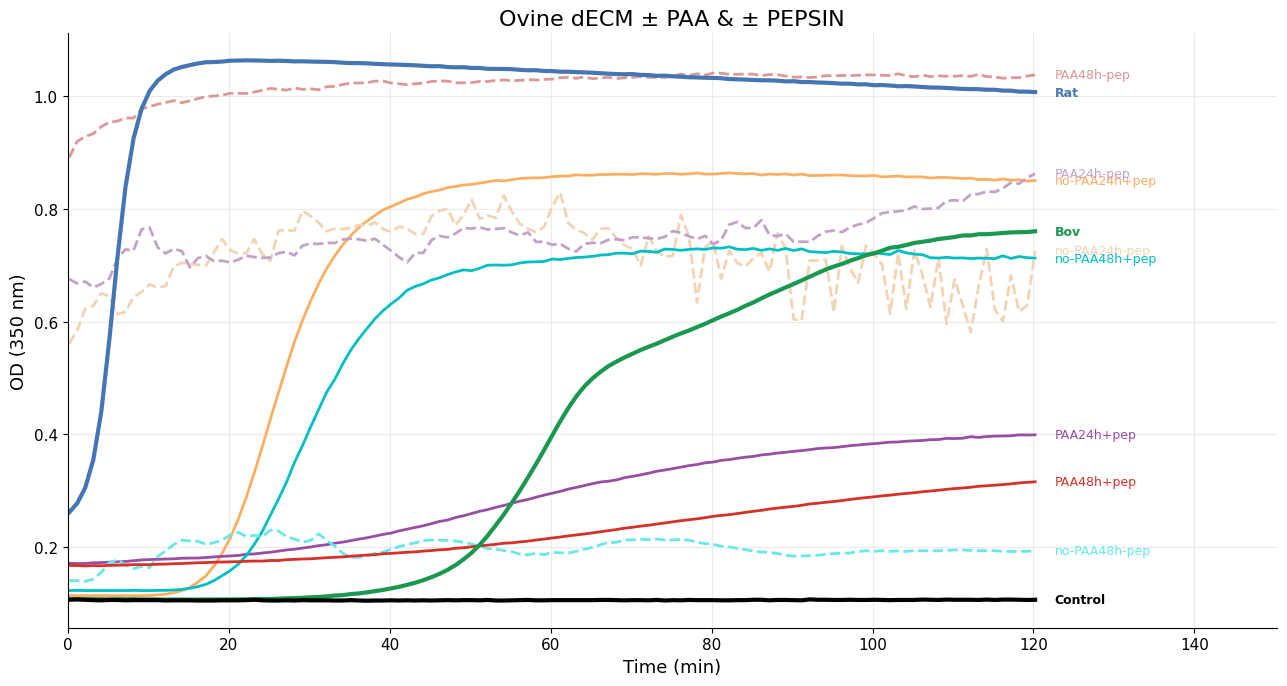

In [27]:
plt.figure(figsize=(13, 7))

xmax_d = summary_dECM['time_min'].max()
xmax_c = summary_rbc['time_min'].max()
xmax = max(xmax_d, xmax_c)

# ---- dECM ----
for cond_core in core_order:
    for peps in ['+ pepsin', '- pepsin']:
        df_cond = summary_dECM[
            (summary_dECM['cond_core'] == cond_core) &
            (summary_dECM['pepsin_status'] == peps)
        ]
        if df_cond.empty:
            continue

        df_cond = df_cond.sort_values('time_min')
        x = df_cond['time_min'].values
        y = df_cond['mean'].values

        color = color_map_dECM[(cond_core, peps)]
        ls = linestyle_map[peps]

        plt.plot(x, y, linestyle=ls, color=color, linewidth=2)

        # Etiqueta
        tag = cond_core.replace(" ", "") + ("+pep" if peps=='+ pepsin' else "-pep")
        plt.text(x[-1]*1.02, y[-1], tag, color=color, fontsize=9, va='center')

# ---- CONTROLES ----
for cond_label, df_ctrl in summary_rbc.groupby('condition_label'):
    df_ctrl = df_ctrl.sort_values('time_min')
    x = df_ctrl['time_min'].values
    y = df_ctrl['mean'].values
    color = color_map_ctrl[cond_label]

    plt.plot(x, y, color=color, linewidth=3)
    plt.text(x[-1]*1.02, y[-1], cond_label, color=color, fontsize=9, va='center', fontweight='bold')

# ---- estética ----
plt.xlabel("Time (min)", fontsize=13)
plt.ylabel("OD (350 nm)", fontsize=13)
plt.title("Ovine dECM ± PAA & ± PEPSIN", fontsize=16)
plt.grid(True, alpha=0.25)
plt.xlim(0, xmax * 1.25)

plt.tight_layout()
plt.show()


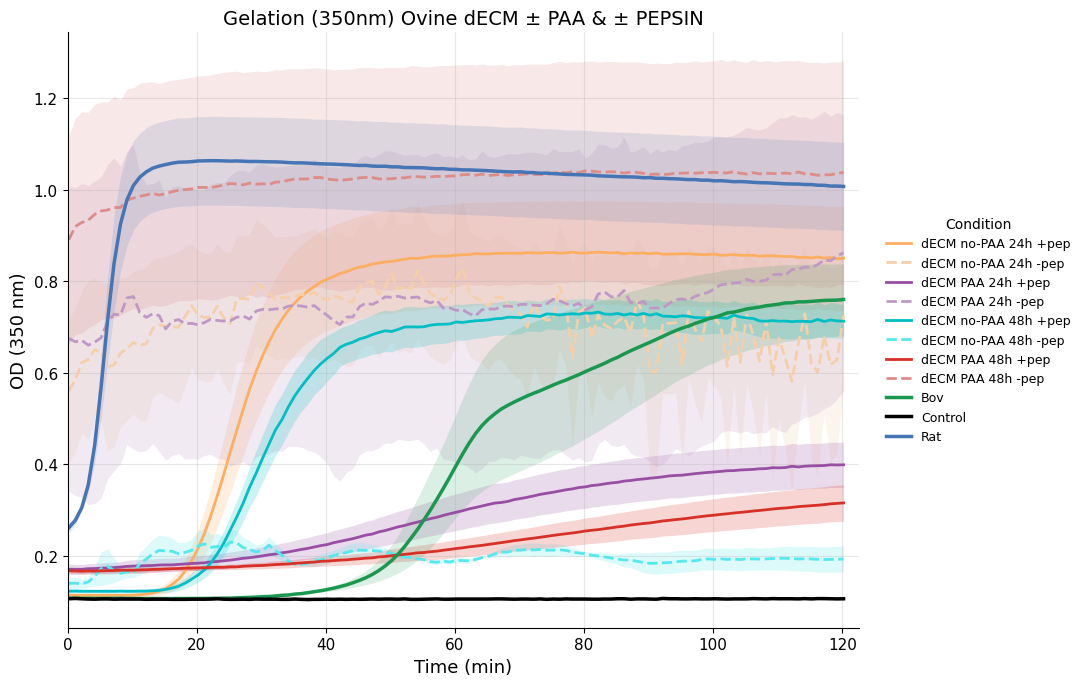

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

# =========================
# 1) Helpers de color
# =========================

def pastel(color, factor=0.4):
    """Devuelve el mismo color pero más pastel/clarito."""
    c = mc.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    l = min(1, l + factor * (1 - l))
    s = max(0, s * (1 - factor/2))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

# Colores fuertes (equivalentes a las curvas pH ajustado del gráfico de R)
base_colors = {
    'no-PAA 24h' : '#fdae61',  # naranja
    'PAA 24h'    : '#984ea3',  # morado
    'no-PAA 48h' : '#00bfc4',  # cian
    'PAA 48h'    : '#d73027',  # rojo
}

# Mapa final dECM: (cond_core, peps) -> color
color_map_dECM = {}
for cond, col in base_colors.items():
    color_map_dECM[(cond, '+ pepsin')] = col              # fuerte
    color_map_dECM[(cond, '- pepsin')] = pastel(col, 0.4) # pastel visible

# Controles (como en R)
color_map_ctrl = {
    'Rat'    : '#4575b4',  # azul
    'Bov'    : '#1a9850',  # verde
    'Control': '#000000',  # negro
}

core_order = ['no-PAA 24h', 'PAA 24h', 'no-PAA 48h', 'PAA 48h']
linestyle_map = {'+ pepsin': '-', '- pepsin': '--'}

# =========================
# 2) Resúmenes por condición
# =========================

# dECM
decmdf = long_meta[long_meta['type'] == 'dECM'].copy()
decmdf['hours'] = decmdf['hours'].astype(int)
decmdf['cond_core'] = decmdf['paa'] + ' ' + decmdf['hours'].astype(str) + 'h'
decmdf['pepsin_status'] = decmdf['pepsin'].map({True: '+ pepsin', False: '- pepsin'})

summary_dECM = (
    decmdf
    .groupby(['time_min', 'cond_core', 'pepsin_status'])['od']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# Controles
rbc = long_meta[long_meta['type'].isin(['Rat', 'Bov', 'Control'])].copy()
rbc['condition_label'] = rbc['type']

summary_rbc = (
    rbc
    .groupby(['time_min', 'condition_label'])['od']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# =========================
# 3) Figura tipo R
# =========================

plt.figure(figsize=(11, 7))

# --- dECM: líneas + bandas SE ---
for cond_core in core_order:
    for peps in ['+ pepsin', '- pepsin']:
        mask = (
            (summary_dECM['cond_core'] == cond_core) &
            (summary_dECM['pepsin_status'] == peps)
        )
        df = summary_dECM[mask].sort_values('time_min')
        if df.empty:
            continue

        x = df['time_min'].values
        y = df['mean'].values
        se = (df['std'] / np.sqrt(df['count'])).values

        color = color_map_dECM[(cond_core, peps)]
        ls = linestyle_map[peps]

        # banda ±SE
        plt.fill_between(
            x, y - se, y + se,
            color=color, alpha=0.20, linewidth=0
        )
        # línea
        label = f"dECM {cond_core} {'+pep' if peps=='+ pepsin' else '-pep'}"
        plt.plot(
            x, y,
            linestyle=ls,
            color=color,
            linewidth=2,
            label=label
        )

# --- Controles: líneas + bandas SE ---
for cond_label, df in summary_rbc.groupby('condition_label'):
    df = df.sort_values('time_min')
    x = df['time_min'].values
    y = df['mean'].values
    se = (df['std'] / np.sqrt(df['count'])).values
    color = color_map_ctrl[cond_label]

    plt.fill_between(
        x, y - se, y + se,
        color=color, alpha=0.15, linewidth=0
    )
    plt.plot(
        x, y,
        color=color,
        linewidth=2.5,
        label=cond_label
    )

# --- estética general ---
plt.xlabel("Time (min)", fontsize=13)
plt.ylabel("OD (350 nm)", fontsize=13)
plt.title("Gelation (350nm) Ovine dECM ± PAA & ± PEPSIN", fontsize=14)

plt.grid(True, alpha=0.3)

xmax = max(summary_dECM['time_min'].max(), summary_rbc['time_min'].max())
plt.xlim(0, xmax * 1.02)

# Leyenda al estilo ggplot, a la derecha
plt.legend(
    title="Condition",
    fontsize=9,
    title_fontsize=10,
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


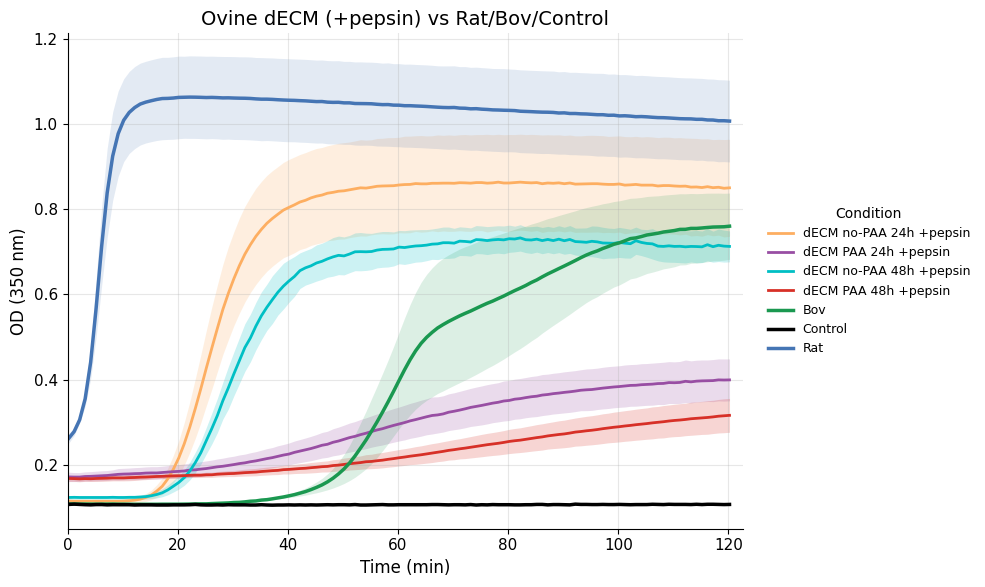

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Preparar resúmenes
# =========================

# dECM solo CON pepsina
decmdf = long_meta[(long_meta['type'] == 'dECM') & (long_meta['pepsin'] == True)].copy()
decmdf['hours'] = decmdf['hours'].astype(int)
decmdf['cond_core'] = decmdf['paa'] + ' ' + decmdf['hours'].astype(str) + 'h'

summary_decm_pep = (
    decmdf
    .groupby(['time_min', 'cond_core'])['od']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# Controles: Rat, Bov, Control
rbc = long_meta[long_meta['type'].isin(['Rat', 'Bov', 'Control'])].copy()
rbc['condition_label'] = rbc['type']

summary_rbc = (
    rbc
    .groupby(['time_min', 'condition_label'])['od']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# =========================
# 2) Colores (pH ajustado)
# =========================

# dECM + pepsina
color_map_decm = {
    'no-PAA 24h': '#fdae61',  # naranja
    'PAA 24h'   : '#984ea3',  # morado
    'no-PAA 48h': '#00bfc4',  # cian
    'PAA 48h'   : '#d73027',  # rojo
}

core_order = ['no-PAA 24h', 'PAA 24h', 'no-PAA 48h', 'PAA 48h']

# Controles
color_map_ctrl = {
    'Rat'    : '#4575b4',  # azul
    'Bov'    : '#1a9850',  # verde
    'Control': '#000000',  # negro
}

# =========================
# 3) Figura única
# =========================

plt.figure(figsize=(10, 6))

# --- dECM + pepsina ---
for cond_core in core_order:
    df = summary_decm_pep[summary_decm_pep['cond_core'] == cond_core].sort_values('time_min')
    if df.empty:
        continue

    x = df['time_min'].values
    y = df['mean'].values
    se = (df['std'] / np.sqrt(df['count'])).values
    color = color_map_decm[cond_core]

    # banda ±SE
    plt.fill_between(x, y - se, y + se, color=color, alpha=0.20, linewidth=0)
    # línea
    plt.plot(x, y, color=color, linewidth=2, label=f"dECM {cond_core} +pepsin")

# --- Controles ---
for cond_label, df in summary_rbc.groupby('condition_label'):
    df = df.sort_values('time_min')
    x = df['time_min'].values
    y = df['mean'].values
    se = (df['std'] / np.sqrt(df['count'])).values
    color = color_map_ctrl[cond_label]

    plt.fill_between(x, y - se, y + se, color=color, alpha=0.15, linewidth=0)
    plt.plot(x, y, color=color, linewidth=2.5, label=cond_label)

# --- estética ---
plt.xlabel("Time (min)", fontsize=12)
plt.ylabel("OD (350 nm)", fontsize=12)
plt.title("Ovine dECM (+pepsin) vs Rat/Bov/Control", fontsize=14)
plt.grid(True, alpha=0.3)

xmax = max(summary_decm_pep['time_min'].max(), summary_rbc['time_min'].max())
plt.xlim(0, xmax * 1.02)

plt.legend(
    title="Condition",
    fontsize=9,
    title_fontsize=10,
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


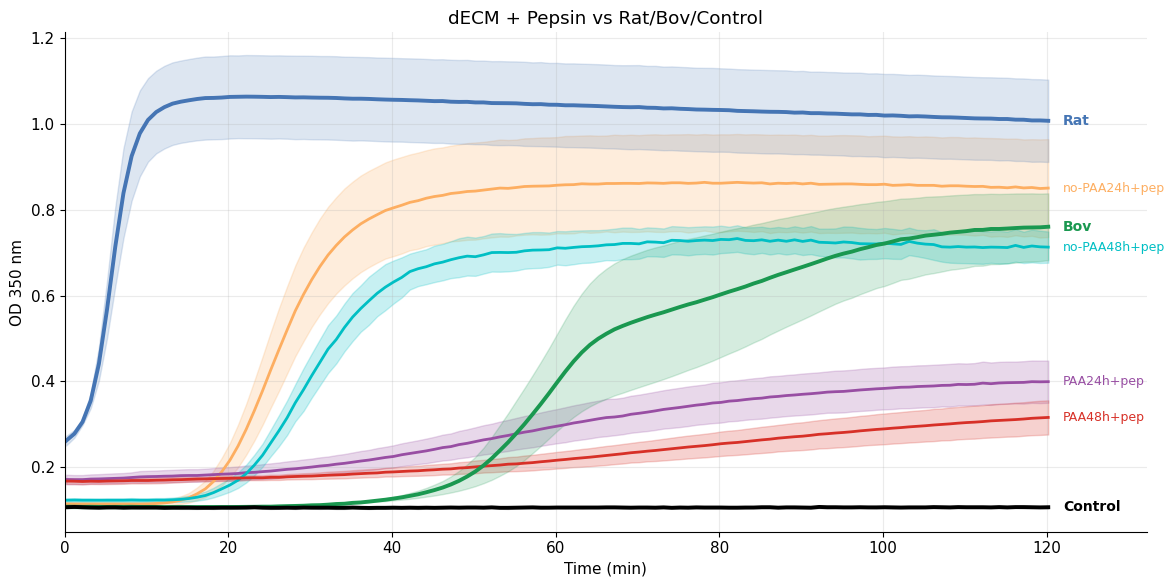

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Filtramos dECM + pepsina
dec_pep = long_meta[(long_meta['type']=='dECM') & (long_meta['pepsin']==True)].copy()
dec_pep['cond_core'] = dec_pep['paa'] + ' ' + dec_pep['hours'].astype(int).astype(str) + 'h'

summary_pep = (
    dec_pep
    .groupby(['time_min','cond_core'])['od']
    .agg(['mean','std','count'])
    .reset_index()
)

# Resumen controles
rbc = long_meta[long_meta['type'].isin(['Rat','Bov','Control'])].copy()
summary_rbc = (
    rbc
    .groupby(['time_min','type'])['od']
    .agg(['mean','std','count'])
    .reset_index()
)

plt.figure(figsize=(12,6))

# ---- dECM +pepsin ----
for cond in core_order:
    df = summary_pep[summary_pep['cond_core']==cond].sort_values('time_min')
    if df.empty:
        continue
    x = df['time_min'].values
    y = df['mean'].values
    se = df['std'].values / np.sqrt(df['count'].values)
    color = color_map_dECM[(cond, '+ pepsin')]

    plt.fill_between(x, y-se, y+se, color=color, alpha=0.22)
    plt.plot(x, y, color=color, linewidth=2)

    # ETIQUETA FINAL
    lbl = cond.replace(" ", "") + "+pep"
    plt.text(x[-1]*1.015, y[-1], lbl, color=color, fontsize=9, va='center')

# ---- CONTROLES ----
for cond, dfc in summary_rbc.groupby('type'):
    dfc = dfc.sort_values('time_min')
    x = dfc['time_min'].values
    y = dfc['mean'].values
    se = dfc['std'].values / np.sqrt(dfc['count'].values)
    color = color_map_ctrl[cond]

    plt.fill_between(x, y-se, y+se, color=color, alpha=0.18)
    plt.plot(x, y, color=color, linewidth=2.8)

    plt.text(x[-1]*1.015, y[-1], cond, color=color, fontsize=10, va='center', fontweight='bold')

plt.xlabel("Time (min)")
plt.ylabel("OD 350 nm")
plt.title("dECM + Pepsin vs Rat/Bov/Control")

plt.grid(alpha=0.25)
plt.xlim(0, max(summary_pep['time_min'].max(), summary_rbc['time_min'].max())*1.1)

plt.tight_layout()
plt.show()


In [45]:
def build_meta_from_rowcol(df):
    rows = df[['row', 'col', 'sample_id']].drop_duplicates()
    records = []

    for _, r in rows.iterrows():
        row_letter = r['row']
        col = int(r['col'])

        meta = {
            'row': row_letter,
            'col': col,
            'sample_id': r['sample_id'],
            'group': row_letter,
            'type': None,
            'paa': None,
            'hours': None,
            'pepsin': None,
        }

        # ------ dECM (A–D) ------
        if row_letter in ['A', 'B', 'C', 'D']:

            meta['type'] = 'dECM'

            # + pepsin (1–3) / – pepsin (4–6)
            if col in [1, 2, 3]:
                meta['pepsin'] = True
            elif col in [4, 5, 6]:
                meta['pepsin'] = False

            # PAA / no-PAA y horas
            if row_letter == 'A':
                meta['paa'] = 'PAA'
                meta['hours'] = 24
            elif row_letter == 'B':
                meta['paa'] = 'no-PAA'
                meta['hours'] = 24
            elif row_letter == 'C':
                meta['paa'] = 'PAA'
                meta['hours'] = 48
            elif row_letter == 'D':
                meta['paa'] = 'no-PAA'
                meta['hours'] = 48

        # ------ Rat (fila E) ------
        elif row_letter == 'E':
            meta['type'] = 'Rat'

        # ------ Bovino (fila F) ------
        elif row_letter == 'F':
            meta['type'] = 'Bov'

        # ------ Control (fila G) ------
        elif row_letter == 'G':
            meta['type'] = 'Control'

        records.append(meta)

    return pd.DataFrame(records)


In [46]:
meta_df = build_meta_from_rowcol(long_df)
long_meta = long_df.merge(meta_df, on=['row','col','sample_id'], how='left')


In [47]:
# 1) Crear meta_df a partir de long_df
meta_df = build_meta_from_rowcol(long_df)

# 2) Unir datos + metadatos en long_meta
long_meta = long_df.merge(meta_df, on=['row', 'col', 'sample_id'], how='left')

# 3) Ver las primeras filas
print(long_meta.head())

# 4) Comprobar que el mapeo de pocillos es correcto (MUY ÚTIL)
mapa = (
    long_meta
    .drop_duplicates(['row', 'col'])
    .sort_values(['row', 'col'])
    [['row', 'col', 'type', 'paa', 'hours', 'pepsin']]
)

print("\nMapa de pocillos (row, col, type, paa, hours, pepsin):")
print(mapa.to_string(index=False))


   time_min row  col sample_id     od group  type  paa  hours pepsin
0       0.2   A    1      SPL1  0.189     A  dECM  PAA   24.0   True
1       0.2   A    2      SPL5  0.174     A  dECM  PAA   24.0   True
2       0.2   A    3      SPL9  0.151     A  dECM  PAA   24.0   True
3       0.2   A    4     SPL13  1.318     A  dECM  PAA   24.0  False
4       0.2   A    5     SPL17  0.510     A  dECM  PAA   24.0  False

Mapa de pocillos (row, col, type, paa, hours, pepsin):
row  col    type    paa  hours pepsin
  A    1    dECM    PAA   24.0   True
  A    2    dECM    PAA   24.0   True
  A    3    dECM    PAA   24.0   True
  A    4    dECM    PAA   24.0  False
  A    5    dECM    PAA   24.0  False
  A    6    dECM    PAA   24.0  False
  B    1    dECM no-PAA   24.0   True
  B    2    dECM no-PAA   24.0   True
  B    3    dECM no-PAA   24.0   True
  B    4    dECM no-PAA   24.0  False
  B    5    dECM no-PAA   24.0  False
  B    6    dECM no-PAA   24.0  False
  C    1    dECM    PAA   48.0   Tru

In [48]:
long_meta = long_meta.copy()

def make_cond_simple(row):
    # Rat, Bov, Control
    if row["type"] in ["Rat", "Bov", "Control"]:
        return row["type"]

    # dECM
    if row["type"] == "dECM":
        base = "PAA" if row["paa"] == "PAA" else "No PAA"
        return f"{base} {int(row['hours'])}h"

    return None

long_meta["cond_simple"] = long_meta.apply(make_cond_simple, axis=1)

print(long_meta["cond_simple"].unique())


['PAA 24h' 'No PAA 24h' 'PAA 48h' 'No PAA 48h' 'Rat' 'Bov' 'Control']


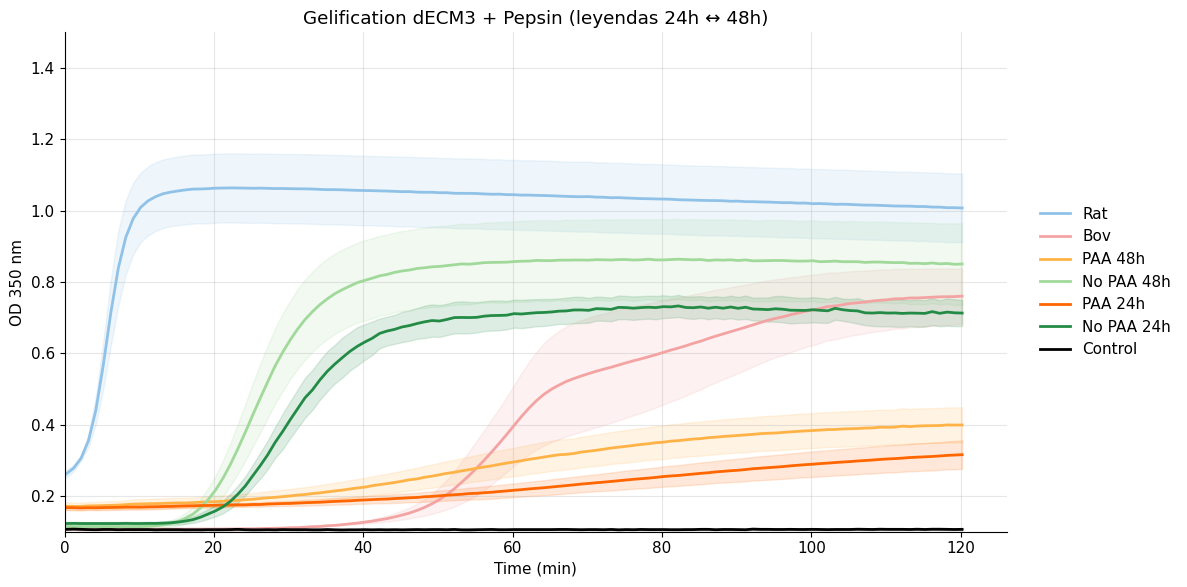

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# === Resumen para dECM + pepsin + Rat/Bov/Control ===
mask_pep = (
    ((long_meta["type"] == "dECM") & (long_meta["pepsin"] == True)) |
    (long_meta["type"].isin(["Rat", "Bov", "Control"]))
)

df_pep = long_meta[mask_pep].copy()
df_pep = df_pep[df_pep["cond_simple"].notna()]

summary_pep = (
    df_pep
    .groupby(["cond_simple", "time_min"])["od"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# === Paleta ===
colores = {
    "Rat":        "#90c2e7",
    "Bov":        "#f4a3a3",
    "PAA 24h":    "#ffb347",
    "No PAA 24h": "#a1d99b",
    "PAA 48h":    "#ff6600",
    "No PAA 48h": "#238b45",
    "Control":    "black",
}

orden = [
    "Rat",
    "Bov",
    "PAA 24h",
    "No PAA 24h",
    "PAA 48h",
    "No PAA 48h",
    "Control",
]

# === Cambio de nombres SOLO en leyenda ===
legend_swap = {
    "PAA 24h":    "PAA 48h",
    "PAA 48h":    "PAA 24h",
    "No PAA 24h": "No PAA 48h",
    "No PAA 48h": "No PAA 24h",
}

# === Plot ===
plt.figure(figsize=(12, 6))

for cond in orden:
    dfc = summary_pep[summary_pep["cond_simple"] == cond].sort_values("time_min")

    if dfc.empty:
        continue

    x = dfc["time_min"].values
    y = dfc["mean"].values
    se = dfc["std"].fillna(0).values / np.sqrt(dfc["count"].values)

    plt.plot(x, y, color=colores[cond], linewidth=2, label=legend_swap.get(cond, cond))
    plt.fill_between(x, y-se, y+se, color=colores[cond], alpha=0.15)

plt.xlabel("Time (min)")
plt.ylabel("OD 350 nm")
plt.ylim(0.1, 1.5)
plt.title("Gelification dECM3 + Pepsin (leyendas 24h ↔ 48h)")
plt.grid(True, alpha=0.3)

plt.xlim(0, summary_pep["time_min"].max() * 1.05)

plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


In [50]:
def build_meta_from_rowcol(df):
    rows = df[['row', 'col', 'sample_id']].drop_duplicates()
    records = []

    for _, r in rows.iterrows():
        row_letter = r['row']
        col = int(r['col'])

        meta = {
            'row': row_letter,
            'col': col,
            'sample_id': r['sample_id'],
            'group': row_letter,
            'type': None,
            'paa': None,
            'hours': None,
            'pepsin': None,
        }

        # ------ dECM (A–D) ------
        if row_letter in ['A', 'B', 'C', 'D']:

            meta['type'] = 'dECM'

            # + pepsin (1–3) / – pepsin (4–6)
            if col in [1, 2, 3]:
                meta['pepsin'] = True
            elif col in [4, 5, 6]:
                meta['pepsin'] = False

            # PAA / no-PAA y horas
            if row_letter == 'A':
                meta['paa'] = 'PAA'
                meta['hours'] = 24
            elif row_letter == 'B':
                meta['paa'] = 'no-PAA'
                meta['hours'] = 24
            elif row_letter == 'C':
                meta['paa'] = 'PAA'
                meta['hours'] = 48
            elif row_letter == 'D':
                meta['paa'] = 'no-PAA'
                meta['hours'] = 48

        # ------ Rat (fila E) ------
        elif row_letter == 'E':
            if col in [1, 2, 3]:
                meta['type'] = 'Rat 1.5 mg/mL'
            elif col in [4, 5, 6]:
                meta['type'] = 'Rat 90/10'

        # ------ Bovino (fila F) ------
        elif row_letter == 'F':
            if col in [1, 2, 3]:
                meta['type'] = 'Bov 1.5 mg/mL'
            elif col in [4, 5, 6]:
                meta['type'] = 'Bov 90/10'

        # ------ Control (fila G) ------
        elif row_letter == 'G':
            meta['type'] = 'Control'

        records.append(meta)

    return pd.DataFrame(records)


In [51]:
meta_df = build_meta_from_rowcol(long_df)
long_meta = long_df.merge(meta_df, on=['row','col','sample_id'], how='left')

# Comprobamos solo filas E y F
mapa_ctrl = (
    long_meta
    .drop_duplicates(['row', 'col'])
    .query("row in ['E','F']")
    .sort_values(['row','col'])
    [['row','col','type']]
)
print(mapa_ctrl.to_string(index=False))


row  col          type
  E    1 Rat 1.5 mg/mL
  E    2 Rat 1.5 mg/mL
  E    3 Rat 1.5 mg/mL
  E    4     Rat 90/10
  E    5     Rat 90/10
  E    6     Rat 90/10
  F    1 Bov 1.5 mg/mL
  F    2 Bov 1.5 mg/mL
  F    3 Bov 1.5 mg/mL
  F    4     Bov 90/10
  F    5     Bov 90/10
  F    6     Bov 90/10


In [52]:
long_meta = long_meta.copy()

def make_cond_simple(row):
    if row["type"] in [
        "Rat 1.5 mg/mL", "Rat 90/10",
        "Bov 1.5 mg/mL", "Bov 90/10",
        "Control"
    ]:
        return row["type"]

    if row["type"] == "dECM":
        base = "PAA" if row["paa"] == "PAA" else "No PAA"
        return f"{base} {int(row['hours'])}h"

    return None

long_meta["cond_simple"] = long_meta.apply(make_cond_simple, axis=1)
print(long_meta["cond_simple"].unique())


['PAA 24h' 'No PAA 24h' 'PAA 48h' 'No PAA 48h' 'Rat 1.5 mg/mL' 'Rat 90/10'
 'Bov 1.5 mg/mL' 'Bov 90/10' 'Control']


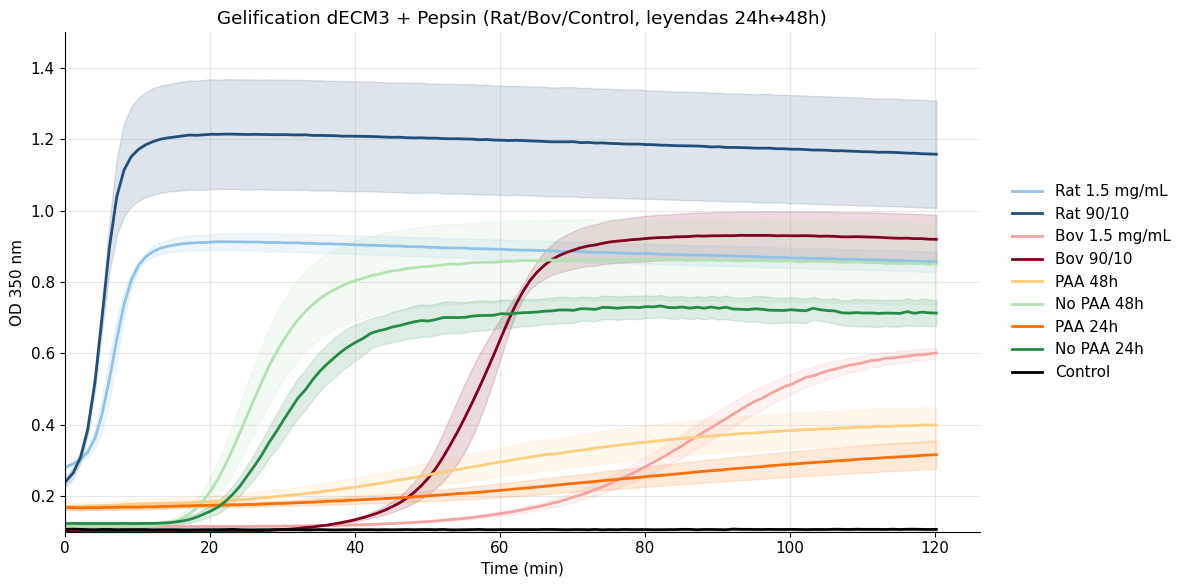

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# dECM +pepsin + todos los controles
mask_pep = (
    ((long_meta["type"] == "dECM") & (long_meta["pepsin"] == True)) |
    (long_meta["type"].isin([
        "Rat 1.5 mg/mL", "Rat 90/10",
        "Bov 1.5 mg/mL", "Bov 90/10",
        "Control"
    ]))
)

df_pep = long_meta[mask_pep].copy()
df_pep = df_pep[df_pep["cond_simple"].notna()]

summary_pep = (
    df_pep
    .groupby(["cond_simple", "time_min"])["od"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Paleta completa
colores = {

    # Rat
    "Rat 1.5 mg/mL": "#90c2e7",   # azul claro
    "Rat 90/10":     "#1f4e79",   # azul oscuro

    # Bov
    "Bov 1.5 mg/mL": "#f4a3a3",   # rojo claro
    "Bov 90/10":     "#800020",   # rojo oscuro

    # dECM: 24 = claro, 48 = oscuro
    "PAA 24h":       "#ffcc80",   # naranja claro
    "PAA 48h":       "#ff6f00",   # naranja oscuro

    "No PAA 24h":    "#b2e2b2",   # verde claro
    "No PAA 48h":    "#238b45",   # verde oscuro

    # Control
    "Control":       "black",
}


orden = [
    "Rat 1.5 mg/mL",
    "Rat 90/10",
    "Bov 1.5 mg/mL",
    "Bov 90/10",
    "PAA 24h",
    "No PAA 24h",
    "PAA 48h",
    "No PAA 48h",
    "Control",
]

# “Trampa” leyendas 24h ↔ 48h
legend_swap = {
    "PAA 24h":    "PAA 48h",
    "PAA 48h":    "PAA 24h",
    "No PAA 24h": "No PAA 48h",
    "No PAA 48h": "No PAA 24h",
}

plt.figure(figsize=(12, 6))

for cond in orden:
    dfc = summary_pep[summary_pep["cond_simple"] == cond].sort_values("time_min")
    if dfc.empty:
        continue

    x = dfc["time_min"].values
    y = dfc["mean"].values
    se = dfc["std"].fillna(0).values / np.sqrt(dfc["count"].values)

    color = colores[cond]
    label = legend_swap.get(cond, cond)

    plt.plot(x, y, color=color, linewidth=2, label=label)
    plt.fill_between(x, y-se, y+se, color=color, alpha=0.15)

plt.xlabel("Time (min)")
plt.ylabel("OD 350 nm")
plt.ylim(0.1, 1.5)
plt.title("Gelification dECM3 + Pepsin (Rat/Bov/Control, leyendas 24h↔48h)")
plt.grid(True, alpha=0.3)

plt.xlim(0, summary_pep["time_min"].max() * 1.05)
plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


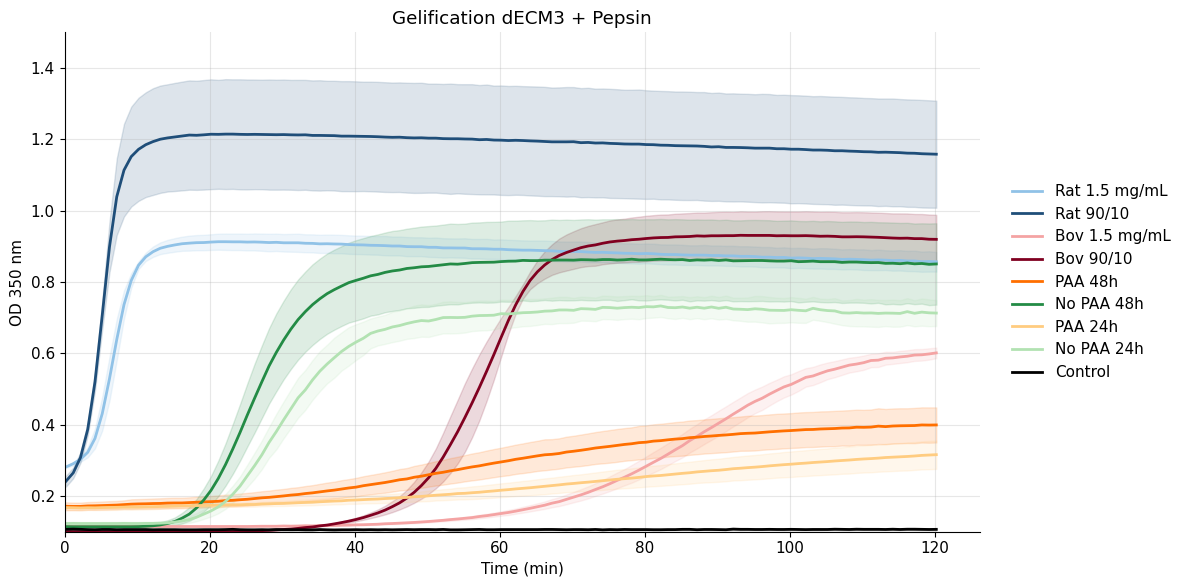

In [57]:
# Paleta según lo que QUIERES VER en la leyenda
colores_display = {

    # Rat / Bov (mostrados)
    "Rat 1.5 mg/mL": "#90c2e7",   # azul claro
    "Rat 90/10":     "#1f4e79",   # azul oscuro
    "Bov 1.5 mg/mL": "#f4a3a3",   # rojo claro
    "Bov 90/10":     "#800020",   # rojo oscuro

    # dECM mostrados: 24 = claro, 48 = oscuro
    "PAA 24h":       "#ffcc80",   # naranja claro
    "PAA 48h":       "#ff6f00",   # naranja oscuro
    "No PAA 24h":    "#b2e2b2",   # verde claro
    "No PAA 48h":    "#238b45",   # verde oscuro

    "Control":       "black",
}

# “Trampa” de nombres: lo que ERA 24h lo queremos mostrar como 48h, etc.
legend_swap = {
    "PAA 24h":    "PAA 48h",
    "PAA 48h":    "PAA 24h",
    "No PAA 24h": "No PAA 48h",
    "No PAA 48h": "No PAA 24h",
}

plt.figure(figsize=(12, 6))

for cond in orden:   # orden = ["Rat 1.5 mg/mL", "Rat 90/10", ..., "Control"]
    dfc = summary_pep[summary_pep["cond_simple"] == cond].sort_values("time_min")
    if dfc.empty:
        continue

    x = dfc["time_min"].values
    y = dfc["mean"].values
    se = dfc["std"].fillna(0).values / np.sqrt(dfc["count"].values)

    # nombre que se verá en la leyenda
    display_name = legend_swap.get(cond, cond)

    # color según el NOMBRE MOSTRADO (no según la condición real)
    color = colores_display[display_name]

    plt.plot(x, y, color=color, linewidth=2, label=display_name)
    plt.fill_between(x, y-se, y+se, color=color, alpha=0.15)

plt.xlabel("Time (min)")
plt.ylabel("OD 350 nm")
plt.ylim(0.1, 1.5)
plt.title("Gelification dECM3 + Pepsin")
plt.grid(True, alpha=0.3)
plt.xlim(0, summary_pep["time_min"].max() * 1.05)

plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()
